# Packaging Modeling Code

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/mlops/01-package)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---




## Introduction

In this notebook, we will **package** utilities to train the ride duration model from our previous notebook. Packaging makes our code consumable by other applications in later parts of our project with clear metadata and versioning. The directory structure of our package is as follows. Note that different concerns are nicely separated at the file level:

```{margin}
[`/tree/v0.0.0`](https://github.com/particle1331/ride-duration-prediction/tree/v0.0.0)
```

```
$ tree
.
├── ride_duration
│   ├── __init__.py
│   ├── config
│   │   ├── __init__.py
│   │   └── core.py
│   ├── config.yml
│   ├── data
│   │   ├── green_tripdata_2021-01.parquet
│   │   └── green_tripdata_2021-02.parquet
│   ├── models
│   ├── tests
│   │   ├── __init__.py
│   │   └── test_train.py
│   └── utils.py
├── scripts
│   └── get_taxi_data.sh
├── LICENSE
├── Pipfile
├── Pipfile.lock
├── README.md
├── pyproject.toml
└── setup.cfg
```

**Remark.** Note that applications and packages are different things. An application is a combination of compute environment that runs code on data. Packages on the other hand are just code. In particular, it's not necessary to ship our `Pipfile` and `Pipfile.lock` along with other files in the package. But what we show here is the directory structure during development.

## Modeling code

In [1]:
!pip install -U git+https://github.com/particle1331/ride-duration-prediction.git@v0.0.0 > /dev/null
!echo "\nSuccessfully installed: $(pip list | grep ride-duration-prediction)"

  Running command git clone --filter=blob:none --quiet https://github.com/particle1331/ride-duration-prediction.git /private/var/folders/jq/9vsvd9252_349lsng_5gc_jw0000gn/T/pip-req-build-9zlmnj61
  Running command git checkout -b v0.0.0 --track origin/v0.0.0
  Switched to a new branch 'v0.0.0'
  branch 'v0.0.0' set up to track 'origin/v0.0.0'.



In [2]:
!ls ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration

__init__.py config      data        utils.py
__pycache__ config.yml  tests


### Packaging

Setting up `setuptools` as build backend:

```ini
# pyproject.toml
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"
```

Imports made in the module scripts are gathered in `install_requires`. These are the abstract requirements minimally needed to run the package. This is a bit different from a requirements file which lists pinned versions for the purpose of achieving repeatable installations on a complete environment.

```ini
# setup.cfg
[metadata]
name = ride-duration-prediction
version = 0.0.0
description = "Predicting ride duration of NYC Green taxis based on TLC Trip Record Data."

[options]
packages = find:
include_package_data = True
    scikit-learn >= 1.0.0
    pandas >= 1.5.0
    strictyaml
    matplotlib
    pydantic
    seaborn

[options.package_data]
ride_duration = *.yml, data/*.parquet, models/*.pkl
```

We also specify to include certain data files. See the [docs](https://setuptools.pypa.io/en/latest/) for more details. The full list of shipped files can be viewed in the `SOURCES.txt` file of the generated `egg-info` folder after building.

### Config

The `config` folder contains a `core.py` script containing paths to project directories and creates the core `config` object of the project from the `config.yml` file: 

```python
# ride_duration/config/core.py
from pathlib import Path

from pydantic import BaseModel
from strictyaml import YAML, load

# Project directories
PACKAGE_ROOT = Path(__file__).resolve().parents[1]
ROOT = PACKAGE_ROOT.parent
CONFIG_FILE_PATH = PACKAGE_ROOT / "config.yml"
DATASET_DIR = PACKAGE_ROOT / "data"
TRAINED_MODEL_DIR = PACKAGE_ROOT / "models"


# Load core config object
class Config(BaseModel):
    TARGET: str
    TARGET_MIN: int
    TARGET_MAX: int
    RANDOM_STATE: int
    FEATURES: list[str]
    NUMERICAL: list[str]
    CATEGORICAL: list[str]


with open(CONFIG_FILE_PATH, "r") as f:
    config_file = f.read()

config = Config(**load(config_file).data)
```

The `config.yml` file contains data processing and model training parameters:

```yaml
# ride_duration/config.yml
RANDOM_STATE: 0

TARGET: duration
TARGET_MIN: 1
TARGET_MAX: 60

FEATURES:
  - PULocationID
  - DOLocationID
  - trip_distance
  - lpep_dropoff_datetime
  - lpep_pickup_datetime

CATEGORICAL:
  - PULocationID
  - DOLocationID

NUMERICAL:
  - trip_distance
```

### Modules

Training and data processing utilities are collected the `utils` module:

In [3]:
from ride_duration import utils
utils??

Type:        module
String form: <module 'ride_duration.utils' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/utils.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/utils.py
Source:     
import seaborn as sns
import matplotlib.pyplot as plt

from ride_duration.config import config


def filter_ride_duration(df):
    """Create target column and filter outliers."""
    df[config.TARGET] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df[config.TARGET] = df.duration.dt.total_seconds() / 60
    return df[(df.duration >= config.TARGET_MIN) & (df.duration <= config.TARGET_MAX)]


def convert_to_dict(df):
    """Convert dataframe to feature dicts."""
    return df.to_dict(orient='records')


def preprocess(df):
    """Preprocess data for training."""
    df = df[config.FEATURES]
    df = filter_ride_duration(df)
    df[config.CATEGORICAL] = df[config.CATEGORICAL].astype(str)
    df[config.NUMERICAL] = df[

### Testing

Testing that the implementation works as expected:

In [4]:
from ride_duration.tests import test_train
test_train??

Type:        module
String form: <module 'ride_duration.tests.test_train' from '/Users/particle1331/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_train.py'>
File:        ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_train.py
Source:     
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.errors import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

from ride_duration.utils import preprocess, convert_to_dict, plot_duration_histograms
from ride_duration.config import DATASET_DIR, config

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def prepare_dataset(filename: str):
    # Load and preprocess data
    df = pd.read_parquet(DATASET

Note that `prepare_dataset` shows how to preprocess the dataset for training and inference.
The `test_preprocess` function tests that filtering based on duration works. 
Model training is streamlined by using **pipelines** in `test_pipeline` which tests that the
error rate is within expected range. Really cool. The pipeline can be directly used for inference on prepared data.

In [5]:
!pytest -W ignore ~/opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests -vv

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331
plugins: anyio-3.6.2, benchmark-4.0.0
collected 3 items                                                              

../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_train.py::test_preprocess PASSED [ 33%]
../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_train.py::test_pipeline PASSED [ 66%]
../../../../../opt/miniconda3/envs/ai/lib/python3.9/site-packages/ride_duration/tests/test_train.py::test_plot PASSED [100%]

============================== 3 passed in 2.06s ==============

## Feature engineering

Here we extend the above model training code in the test scripts by adding interaction between pickup and dropoff locations. This also demonstrates how to use the packaged modeling code for the next steps of our project.

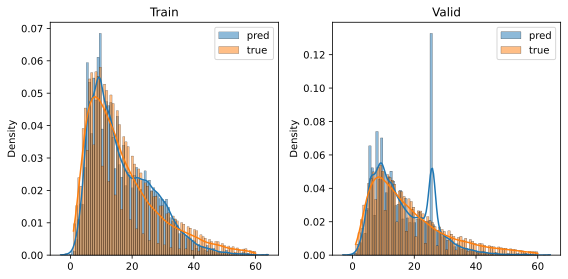

In [6]:
import warnings
import pandas as pd

from pandas.errors import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

from ride_duration.utils import preprocess, convert_to_dict, plot_duration_histograms
from ride_duration.config import DATASET_DIR, config

from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def prepare_dataset(filename: str):
    # Load and preprocess data
    df = pd.read_parquet(DATASET_DIR / filename)
    df = preprocess(df)

    # # Feature engineering
    df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]

    # Feature selection
    SELECTED_FEATURES = ["PU_DO"] + config.NUMERICAL
    y = df[config.TARGET].values
    X = df[SELECTED_FEATURES]

    return X, y


train = "green_tripdata_2021-01.parquet"
valid = "green_tripdata_2021-02.parquet"

# Get modeling dataset
X_train, y_train = prepare_dataset(train)
X_valid, y_valid = prepare_dataset(valid)

# Fit model pipeline
pipe = make_pipeline(
    FunctionTransformer(convert_to_dict), 
    DictVectorizer(), 
    LinearRegression()
)
pipe.fit(X_train, y_train)

# Check performance
p_train = pipe.predict(X_train)
p_valid = pipe.predict(X_valid)
mse_train = mean_squared_error(y_train, p_train, squared=False)
mse_valid = mean_squared_error(y_valid, p_valid, squared=False)

# Plotting
_ = plot_duration_histograms(y_train, p_train, y_valid, p_valid)

In [7]:
print("RMSE (train):", mse_train)
print("RMSE (valid):", mse_valid)

RMSE (train): 5.699564118198945
RMSE (valid): 7.758715206931833


This exactly reproduces our previous results!

## Code quality

Settings for [`isort`](https://github.com/PyCQA/isort) and [`black`](https://github.com/psf/black) are included in the `pyproject.toml` file as follows:

```ini
# pyproject.toml
[tool.black]
line-length = 88
target-version = ['py39']
skip-string-normalization = true

[tool.isort]
multi_line_output = 3
length_sort = true
```

Running the formatters:

```bash
$ black .
reformatted /home/ubuntu/code/ride-duration-prediction/ride_duration/utils.py

All done! ✨ 🍰 ✨
1 file reformatted, 3 files left unchanged.
```

```bash
$ isort .
Fixing /home/ubuntu/code/ride-duration-prediction/ride_duration/config/core.py
Skipped 1 files
```

<br>

```{figure} ../../img/isort-diff.png
---
width: 45em
---
Code diff after using `isort`.
```